## packages

In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import tensorflow as tf
from tensorflow import keras


## data pre-processing

### learn the data

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
# train.shape = (42000,785), 42000 records, each record size is 1+28*28 
# test.shape = (28000,784), no label column, each record size is 28*28
train.shape,test.shape

((42000, 785), (28000, 784))

In [3]:
# extract ytrain
ytrain = train['label']
xtrain = train.drop('label',axis=1)
ntrain = xtrain.shape[0]
# dimension
dim = np.sqrt(xtrain.shape[1]).astype(np.int64)

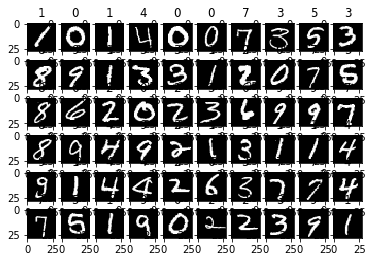

In [4]:
xtrain_vis = xtrain.values.reshape(ntrain,dim,dim)
for i in range(0,60):
    plt.subplot(6,10,1+i)
    plt.imshow(xtrain_vis[i],cmap=plt.get_cmap('gray'))
    plt.title(ytrain[i])

### pre-processing

In [5]:
# normalization
xtrain = xtrain / 255.0
test = test / 255.0

In [6]:
# reshape image
def df_reshape(df):
    df = df.values.reshape(-1,dim,dim,1)
    print("after reshape, pixels are 28*28*1 3D matrix:",df.shape)
    return df

xtrain = df_reshape(xtrain)
test = df_reshape(test)

after reshape, pixels are 28*28*1 3D matrix: (42000, 28, 28, 1)
after reshape, pixels are 28*28*1 3D matrix: (28000, 28, 28, 1)


In [7]:
ytrain.shape

(42000,)

In [8]:
# change ytrain to one-hot vectors
depth = ytrain.max() - ytrain.min() + 1
ytrain = pd.get_dummies(ytrain)

In [9]:
# split CV
from sklearn.model_selection import train_test_split
seed = 2
np.random.seed(seed)
split = 0.1
xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain,test_size=split,random_state=seed,stratify=ytrain)
print(xtrain.shape,xval.shape,ytrain.shape,yval.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


## construct CNN

In [10]:
from tensorflow.keras import backend as K
# structure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Lambda,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPool2D,AvgPool2D
# optimizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [11]:
model = Sequential()
dim = 28
nclasses = 10

In [12]:
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='valid',activation='relu',input_shape=(dim,dim,1)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(120,activation='relu'))
model.add(Dense(nclasses,activation='softmax'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               553080    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1210      
Total params: 555,122
Trainable params: 555,122
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
# learning rate reduce
lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [16]:
datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=30,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

datagen.fit(xtrain)

In [17]:
epochs = 15
batch_size = 64

In [18]:

history = model.fit_generator(datagen.flow(xtrain,ytrain, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(xval,yval),
                              verbose=1, 
                              steps_per_epoch=xtrain.shape[0] // batch_size, 
                              callbacks=[lr_reduction])

Epoch 1/15
590/590 [==============================] - 13s 22ms/step - loss: 0.5218 - acc: 0.8353 - val_loss: 0.1075 - val_acc: 0.9650
Epoch 2/15
590/590 [==============================] - 12s 20ms/step - loss: 0.2061 - acc: 0.9366 - val_loss: 0.0770 - val_acc: 0.9752
Epoch 3/15
590/590 [==============================] - 11s 19ms/step - loss: 0.1579 - acc: 0.9517 - val_loss: 0.0573 - val_acc: 0.9821
Epoch 4/15
590/590 [==============================] - 10s 16ms/step - loss: 0.1301 - acc: 0.9589 - val_loss: 0.0508 - val_acc: 0.9836
Epoch 5/15
590/590 [==============================] - 10s 16ms/step - loss: 0.1147 - acc: 0.9641 - val_loss: 0.0570 - val_acc: 0.9821
Epoch 6/15
590/590 [==============================] - 10s 16ms/step - loss: 0.1084 - acc: 0.9669 - val_loss: 0.0439 - val_acc: 0.9831
Epoch 7/15
587/590 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9703
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
590/590 [================

In [19]:
from sklearn.metrics import confusion_matrix
import itertools

# Predict the values from the validation dataset
ypred_onehot = model.predict(xval)
# Convert predictions classes from one hot vectors to labels: [0 0 1 0 0 ...] --> 2
ypred = np.argmax(ypred_onehot,axis=1)
# Convert validation observations from one hot vectors to labels
ytrue = np.argmax(yval.values,axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(ytrue, ypred)

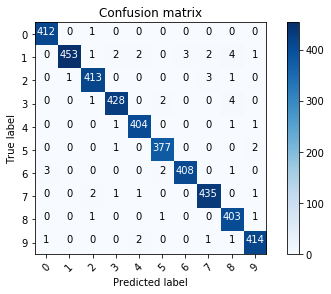

In [20]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(nclasses))

## evaluation and optimization

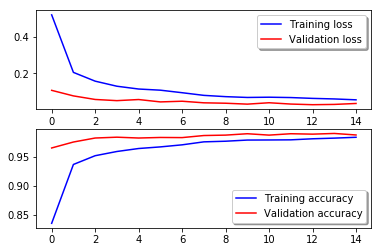

In [21]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

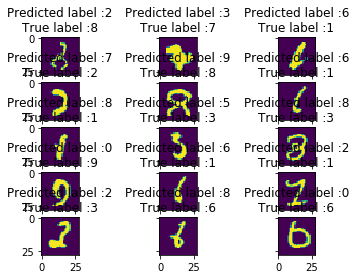

In [22]:
errors = (ypred - ytrue != 0) # array of bools with true when there is an error or false when the image is cor

ypred_er = ypred_onehot[errors]
ypred_classes_er = ypred[errors]
ytrue_er = ytrue[errors]
xval_er = xval[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 5
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            
# Probabilities of the wrong predicted numbers
ypred_er_prob = np.max(ypred_er,axis=1)

# Predicted probabilities of the true values in the error set
true_prob_er = np.diagonal(np.take(ypred_er, ytrue_er, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_er = ypred_er_prob - true_prob_er

# Sorted list of the delta prob errors
sorted_delta_er = np.argsort(delta_pred_true_er)

# Top 6 errors. You can change the range to see other images
most_important_er = sorted_delta_er[-15:]

# Show the top 6 errors
display_errors(most_important_er, xval_er, ypred_classes_er, ytrue_er)

In [23]:
predictions = model.predict_classes(test, verbose=1)

submissions = pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                            "Label": predictions})

submissions.to_csv("mnist2908.csv", index=False, header=True)

28000/28000 [==============================] - 2s 83us/step
